## Importing Libraries

In [33]:
import pandas as pd
import numpy as np
import datetime
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Importing Data

In [2]:
building = pd.read_feather("building_metadata.feather")
train = pd.read_feather('train.feather')
weather = pd.read_feather("weather_train.feather")

In [3]:
train.head()

,building_id,meter,timestamp,meter_reading
0,105,0,2016-01-01 00:00:00,23.3036
1,106,3,2016-01-01 00:00:00,0.0000
2,108,0,2016-01-01 00:00:00,91.2653
3,109,0,2016-01-01 00:00:00,80.9300
4,109,3,2016-01-01 00:00:00,0.0000


In [4]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [5]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [6]:
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [7]:
def label_encoding(df,column_name): 
    
    """Label encoding column name from a data frame"""
    
    le = LabelEncoder()
    df[''+column_name+''] = le.fit_transform(df[''+column_name+''])
    

In [8]:
label_encoding(building,"primary_use")

In [9]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


In [10]:
train.head()

,building_id,meter,timestamp,meter_reading
0,105,0,2016-01-01 00:00:00,23.3036
1,106,3,2016-01-01 00:00:00,0.0000
2,108,0,2016-01-01 00:00:00,91.2653
3,109,0,2016-01-01 00:00:00,80.9300
4,109,3,2016-01-01 00:00:00,0.0000


In [11]:
def add_time_stamp_features(df,timestamp_colname):
    
    """Adding time stamp features"""
    
    df["datetime"] = pd.to_datetime(df[''+timestamp_colname+''])
    df["day"] = df["datetime"].dt.day
    df["week"] = df["datetime"].dt.week
    df["month"] = df["datetime"].dt.month

In [12]:
def weather_data_filler(df,column,by='mean'):
    
    """Filling data by mean/count/min/max/mode"""
    
    if by=='mean':
        filler = pd.DataFrame(df.groupby(['site_id','day','month'])[[''+column+'']].mean(),columns=[''+column+''])
    elif by=='count':
        filler = pd.DataFrame(df.groupby(['site_id','day','month'])[[''+column+'']].count(),columns=[''+column+''])
    elif by=='min':
        filler = pd.DataFrame(df.groupby(['site_id','day','month'])[''+column+''].min(),columns=[''+column+''])
    elif by=='max':
        filler = pd.DataFrame(df.groupby(['site_id','day','month'])[''+column+''].max(),columns=[''+column+''])
    elif by=='mode':
        filler = pd.DataFrame(df.groupby(['site_id','day','month'])[''+column+''].mode(),columns=[''+column+''])
    
    df.update(filler,overwrite=False)


In [13]:
def weather_data_filler_1(df,column,method='ffill',by='mean'):
    
    """Filling the NA values by forward fill and then by mean"""
    
    if by=='mean':
        filler = df.groupby(['site_id','day','month'])[''+column+''].mean()
    elif by=='count':
        filler = df.groupby(['site_id','day','month'])[''+column+''].count()
    elif by=='min':
        filler = df.groupby(['site_id','day','month'])[''+column+''].min()
    elif by=='max':
        filler = df.groupby(['site_id','day','month'])[''+column+''].max()
    elif by=='mode':
        filler = df.groupby(['site_id','day','month'])[''+column+''].mode()    
    
    filler = pd.DataFrame(filler.fillna(method=method),columns=[''+column+''])

    df.update(filler,overwrite=False)
    


In [14]:
def fill_weather_dataset_mean(weather_df):
    
    """Filling weather data by mean"""
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new timestamp Features 
    add_time_stamp_features(weather_df,"timestamp")
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    weather_data_filler(weather_df,"air_temperature",by='mean')
    
    
    weather_data_filler_1(weather_df,"cloud_coverage",method='ffill',by='mean')

    weather_data_filler(weather_df,"dew_temperature",by='mean')

    weather_data_filler_1(weather_df,"sea_level_pressure",method='ffill',by='mean')

    weather_data_filler(weather_df,"wind_direction",by='mean')

    weather_data_filler(weather_df,"wind_speed",by='mean')
    
    weather_data_filler_1(weather_df,"precip_depth_1_hr",method='ffill',by='mean')
    
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

In [15]:
def fill_weather_dataset_max(weather_df):
    
    
    """Filling weather data NA values by max"""
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new timestamp Features 
    add_time_stamp_features(weather_df,"timestamp")
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    weather_data_filler(weather_df,"air_temperature",by='max')
    
    
    weather_data_filler_1(weather_df,"cloud_coverage",method='ffill',by='max')

    weather_data_filler(weather_df,"dew_temperature",by='max')

    weather_data_filler_1(weather_df,"sea_level_pressure",method='ffill',by='max')

    weather_data_filler(weather_df,"wind_direction",by='max')

    weather_data_filler(weather_df,"wind_speed",by='max')
    
    weather_data_filler_1(weather_df,"precip_depth_1_hr",method='ffill',by='max')
    
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

In [16]:
def fill_weather_dataset_min(weather_df):
    
    """Filling weather data NA values by min"""
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new timestamp Features 
    add_time_stamp_features(weather_df,"timestamp")
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    weather_data_filler(weather_df,"air_temperature",by='min')
    
    
    weather_data_filler_1(weather_df,"cloud_coverage",method='ffill',by='min')

    weather_data_filler(weather_df,"dew_temperature",by='min')

    weather_data_filler_1(weather_df,"sea_level_pressure",method='ffill',by='min')

    weather_data_filler(weather_df,"wind_direction",by='min')

    weather_data_filler(weather_df,"wind_speed",by='min')
    
    weather_data_filler_1(weather_df,"precip_depth_1_hr",method='ffill',by='min')
    
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

In [17]:
weather_fill = fill_weather_dataset_mean(weather)
weather_fill.head()

/var/folders/1k/b7pw0m1j39dfh9mmcdvcgsqr0000gn/T/ipykernel_1099/894093638.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week"] = df["datetime"].dt.week


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.000000,20.0,-0.173913,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,4.285714,21.1,-1.000000,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.000000,21.1,0.000000,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.000000,20.6,0.000000,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.000000,20.0,-1.000000,1020.0,250.0,2.6


## Merging 3 dataframes

In [ ]:
%%time
train = train.merge(building, left_on='building_id',right_on='building_id',how='left')

In [ ]:
%%time
train = train.merge(weather_fill,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])

In [20]:
train.head()

,level_0,index,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,103,105,0,2016-01-01 00:00:00,23.3036,1,0,50623,NaN,5.0,3.8,0.0,2.4,0.0,1020.9,240.0,3.1
1,1,105,106,3,2016-01-01 00:00:00,0.0000,1,0,5374,NaN,4.0,3.8,0.0,2.4,0.0,1020.9,240.0,3.1
2,2,107,108,0,2016-01-01 00:00:00,91.2653,1,0,81580,1913.0,5.0,3.8,0.0,2.4,0.0,1020.9,240.0,3.1
3,3,108,109,0,2016-01-01 00:00:00,80.9300,1,0,56995,1953.0,6.0,3.8,0.0,2.4,0.0,1020.9,240.0,3.1
4,4,109,109,3,2016-01-01 00:00:00,0.0000,1,0,56995,1953.0,6.0,3.8,0.0,2.4,0.0,1020.9,240.0,3.1


In [21]:
len(train)

19464335

In [22]:
def log_transform(df,column):
    
    """Log Transformation of dataframe column"""
    df[''+column+''] =  np.log1p(df[''+column+''])
    
    

In [23]:
def log_transform_1(df,column):
    
    """Returning Log Transformation of dataframe column"""
    return np.log1p(df[''+column+''])



In [24]:
def drop_site_0(df):
    
    """Dropping inconsistent columns mentioned in the discussion"""
    df = df[(df.timestamp >= 3378) | (df.site_id != 0) | (df.meter != 0)]

In [25]:
def add_time_stamp_cols(df,time_stamp_col):
    
    """Adding time stamp columns"""
    
    df[''+time_stamp_col+'']=pd.to_datetime(df[''+time_stamp_col+''],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df[''+time_stamp_col+''].dt.hour
    df["weekend"] = df[''+time_stamp_col+''].dt.weekday
    

In [26]:
def add_new_features(df):
    
    """Adding Timestamp features, removing outliers and label encoding the primary_use column"""
    
    df['timestamp']=pd.to_datetime(df['timestamp'])
    
    df.timestamp = (df.timestamp - pd.to_datetime("2016-01-01")).dt.total_seconds() // 3600
    
    df.assign(tm_day_of_week=((df.timestamp // 24) % 7), tm_hour_of_day=(df.timestamp % 24))
    
    drop_site_0(df)
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    add_time_stamp_cols(df,"timestamp")
    
    log_transform(df,'square_feet')
    
     #Dropping electrical zeros
    df = df[(df["meter_reading"] > 0) | (df.meter != 0)]
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    label_encoding(df,"primary_use")
    
    return df

In [27]:
train_new = train

In [28]:
featured = add_new_features(train_new)

In [29]:
featured.head()

,level_0,index,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend
0,0,103,105,0,23.3036,1,0,10.832181,3.8,0.0,2.4,0.0,0,3
1,1,105,106,3,0.0000,1,0,8.589514,3.8,0.0,2.4,0.0,0,3
2,2,107,108,0,91.2653,1,0,11.309352,3.8,0.0,2.4,0.0,0,3
3,3,108,109,0,80.9300,1,0,10.950736,3.8,0.0,2.4,0.0,0,3
4,4,109,109,3,0.0000,1,0,10.950736,3.8,0.0,2.4,0.0,0,3


Taking log of meter reading

In [30]:
target=log_transform_1(featured,"meter_reading")

features = featured.drop('meter_reading', axis = 1)

## Final Data

In [31]:
features

,level_0,index,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend
0,0,103,105,0,1,0,10.832181,3.8,0.0,2.4,0.0,0,3
1,1,105,106,3,1,0,8.589514,3.8,0.0,2.4,0.0,0,3
2,2,107,108,0,1,0,11.309352,3.8,0.0,2.4,0.0,0,3
3,3,108,109,0,1,0,10.950736,3.8,0.0,2.4,0.0,0,3
4,4,109,109,3,1,0,10.950736,3.8,0.0,2.4,0.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19464329,19464329,20216094,1443,0,15,0,10.604404,1.7,2.0,-5.6,-1.0,0,3
19464330,19464330,20216095,1444,0,15,1,9.884305,1.7,2.0,-5.6,-1.0,0,3
19464331,19464331,20216096,1445,0,15,0,8.366138,1.7,2.0,-5.6,-1.0,0,3
19464333,19464333,20216098,1447,0,15,4,10.301458,1.7,2.0,-5.6,-1.0,0,3


## LGBM

In [34]:
def LGBM(categorical_features,params,splits,X,y):

    kf = KFold(n_splits=splits)
    models = []
    for train_index,test_index in kf.split(X):
        train_features = X.iloc[train_index]
        train_target = y.iloc[train_index]
        
        test_features = X.iloc[test_index]
        test_target = y.iloc[test_index]
        
        d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features)
        d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features)
        
        model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
        models.append(model)
        
        del train_features, train_target, test_features, test_target, d_training, d_test
        
        gc.collect()
    return models

In [35]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]

params = {
    "objective": "regression",
    "boosting": "gbdt",
     "num_leaves": 1280,
    "learning_rate": 0.05,
     "feature_fraction": 0.85,
     "reg_lambda": 2,
    "metric": "rmse",
}

model_LGBM=LGBM(categorical_features,params,3,features,target)

/Users/kmallik06/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/kmallik06/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/kmallik06/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 12932826, number of used features: 10


/Users/kmallik06/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/kmallik06/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4.317472
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.991747	valid_1's rmse: 1.14252
[50]	training's rmse: 0.819946	valid_1's rmse: 1.03008
[75]	training's rmse: 0.788448	valid_1's rmse: 1.02377
[100]	training's rmse: 0.773038	valid_1's rmse: 1.02609
[125]	training's rmse: 0.761518	valid_1's rmse: 1.02854
Early stopping, best iteration is:
[79]	training's rmse: 0.78497	valid_1's rmse: 1.02361
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 12932826, number of used features: 10
[LightGBM] [Info] Start training from score 4.243165
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.01437	valid_1's rmse: 1

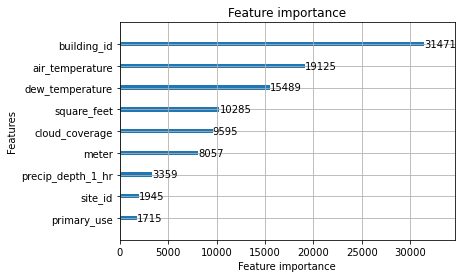

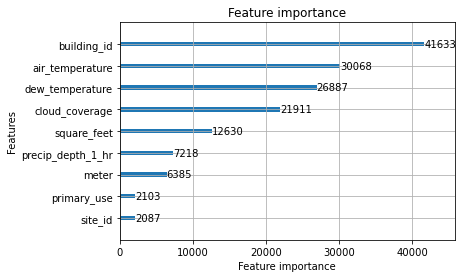

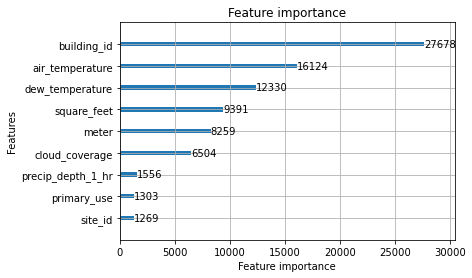

In [36]:
for model in model_LGBM:
    lgb.plot_importance(model)
    plt.show()

In [37]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

### Halving Grid Search for best parameters

### Bayesian Optimization

In [ ]:
!conda install -c conda-forge scikit-optimize
from skopt import BayesSearchCV

search = BayesSearchCV(model, parameters, n_jobs=5)
search.fit(X_train,y_train)

print(search.best_params_)

In [52]:
%%time
results = []
for model in model_LGBM:
    if  results == []:
        results = model.predict(X_test, num_iteration=model.best_iteration) / len(model_LGBM)
    else:
        results += model.predict(X_test, num_iteration=model.best_iteration) / len(model_LGBM)
    del model

<timed exec>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


CPU times: user 5min 38s, sys: 4.43 s, total: 5min 43s
Wall time: 44.7 s


In [54]:
print("Results for LGBM:")
print("-------------------")
all_results(results,y_test)

Results for LGBM:
-------------------
Root Mean Squared Loss Error is: 0.725027761909279
Mean Absolute Error is: 147.5348687679292
Root Mean Squared Error is: 4011.913129196977


## Linear Regression

In [40]:
def LinearRegression(X_train,y_train):
    
    """Implementing Linear Regression Algorithm"""
    
    from sklearn import linear_model
    mod = linear_model.LinearRegression()
    mod.fit(X_train, y_train)
    return mod

## CatBoost

In [41]:
def CatBoost(X_train,y_train,categorical_features,num_iters,learning_rate,n_depth):
    
    """Implementing CatBoost Algorithm with learning_rate,depth of tree, 
    categorical features and number of iterations as parameters"""
    
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import mean_squared_error
    from catboost import CatBoostRegressor


    model=CatBoostRegressor(iterations=num_iters, 
                        depth=n_depth, learning_rate=learning_rate, 
                        loss_function='RMSE')


    model.fit(X_train, y_train,cat_features=categorical_features)
    
    return model

In [42]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]

cat_model=CatBoost(X_train,y_train,categorical_features,10,0.05,3)

0:	learn: 2.0157520	total: 2.07s	remaining: 18.6s
1:	learn: 1.9809471	total: 3.33s	remaining: 13.3s
2:	learn: 1.9491346	total: 4.28s	remaining: 9.99s
3:	learn: 1.9193384	total: 5.03s	remaining: 7.55s
4:	learn: 1.8923132	total: 5.83s	remaining: 5.83s
5:	learn: 1.8670060	total: 6.6s	remaining: 4.4s
6:	learn: 1.8436990	total: 7.17s	remaining: 3.07s
7:	learn: 1.8224067	total: 7.86s	remaining: 1.96s
8:	learn: 1.8023780	total: 8.45s	remaining: 939ms
9:	learn: 1.7843993	total: 9s	remaining: 0us


## XGBoost

In [43]:

def XGBoost(X_train,y_train,X_test,y_test,pars,Early_stopping_rounds):
    
    """Implementing XGBoost Algorithm with parameters and Early stop rounds as parameters"""
    
    import xgboost as xgb
    xgb_train = xgb.DMatrix(X_train, y_train)
    xgb_eval = xgb.DMatrix(X_test, y_test)


    model = xgb.train(pars,
                      xgb_train,
                      num_boost_round=50,
                      evals=[(xgb_train, 'train'), (xgb_eval, 'val')],
                      verbose_eval=5,
                      early_stopping_rounds=Early_stopping_rounds
                     )
    return model

In [44]:
pars = {
    'colsample_bytree': 0.8,                 
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'objective': 'reg:squarederror',
}
XGB_model=XGBoost(X_train,y_train,X_test,y_test,pars,5)

[0]	train-rmse:3.93197	val-rmse:3.93421
[5]	train-rmse:2.70864	val-rmse:2.70910
[10]	train-rmse:2.08697	val-rmse:2.08755
[15]	train-rmse:1.75107	val-rmse:1.75189
[20]	train-rmse:1.60220	val-rmse:1.60316
[25]	train-rmse:1.52154	val-rmse:1.52250
[30]	train-rmse:1.46420	val-rmse:1.46506
[35]	train-rmse:1.42418	val-rmse:1.42517
[40]	train-rmse:1.39969	val-rmse:1.40073
[45]	train-rmse:1.38113	val-rmse:1.38224
[49]	train-rmse:1.36803	val-rmse:1.36918


In [45]:
def all_results(test,pred):
    
    """This Method has all results with Mean Absolute Error, Root Mean Square Log Error 
    and Root Mean Squared Error"""
    
    test=np.abs(test)
    test=np.expm1(test)
    pred=np.abs(pred)
    pred=np.expm1(pred)
    
    step1=pred-test
    step2=np.power(step1,2).mean()
    step3_rmse=np.sqrt(step2)
    

    step1=np.array(test)-np.array(pred)
    step2=step1.mean()
    step3_mae=np.abs(step2)

    print(f'Root Mean Squared Loss Error is: {np.sqrt(mean_squared_log_error(test,pred))}')    
    print(f'Mean Absolute Error is: {step3_mae}')
    print(f'Root Mean Squared Error is: {step3_rmse}')   
    

In [46]:
def post_processing(model,X_train,y_train,X_test,y_test,Algorithm):
    
    """Implemented all post processing from predicting the test and test to printing results"""

    if Algorithm=='XGBoost':
        y_pred_train=model.predict(xgb.DMatrix(X_train))
        y_pred_test=model.predict(xgb.DMatrix(X_test))
        print("Train Results for XGBoost Model:")
        print("---------------------------------")
        all_results(y_pred_train,y_train)
        print("---------------------------------")
        print("Test Results for XGBoost Model:")
        print("---------------------------------")
        all_results(y_pred_test,y_test)
        print("---------------------------------")
    else:
        y_pred_train=model.predict(X_train)
        y_pred_test=model.predict(X_test)
        print(f"Train Results for {Algorithm} Model:")
        print("---------------------------------")
        all_results(y_pred_train,y_train)
        print("---------------------------------")
        print(f"Test Results for {Algorithm} Model:")
        print("---------------------------------")
        all_results(y_pred_test,y_test)
        print("---------------------------------")


In [47]:
post_processing(cat_model,X_train,y_train,X_test,y_test,Algorithm='CatBoost')

Train Results for CatBoost Model:
---------------------------------
Root Mean Squared Loss Error is: 1.7840924024349138
Mean Absolute Error is: 397.450193728056
Root Mean Squared Error is: 4337.630246230362
---------------------------------
Test Results for CatBoost Model:
---------------------------------
Root Mean Squared Loss Error is: 1.7831751336196153
Mean Absolute Error is: 395.63271648711935
Root Mean Squared Error is: 4292.92735703266
---------------------------------


In [48]:
post_processing(XGB_model,X_train,y_train,X_test,y_test,Algorithm='XGBoost')

Train Results for XGBoost Model:
---------------------------------
Root Mean Squared Loss Error is: 1.3692506383045815
Mean Absolute Error is: 312.4407968076451
Root Mean Squared Error is: 4240.735275807244
---------------------------------
Test Results for XGBoost Model:
---------------------------------
Root Mean Squared Loss Error is: 1.3693399086552314
Mean Absolute Error is: 310.7197093621941
Root Mean Squared Error is: 4195.523322727688
---------------------------------


In [49]:
linear=LinearRegression(X_train,y_train)
post_processing(linear,X_train,y_train,X_test,y_test,Algorithm='Linear Regression')

Train Results for Linear Regression Model:
---------------------------------
Root Mean Squared Loss Error is: 1.7806142754765224
Mean Absolute Error is: 369.14122450379915
Root Mean Squared Error is: 4329.649442970963
---------------------------------
Test Results for Linear Regression Model:
---------------------------------
Root Mean Squared Loss Error is: 1.7801424409701736
Mean Absolute Error is: 367.2596353841863
Root Mean Squared Error is: 4284.779501216426
---------------------------------
